In [1]:
"""This should be the main module for the python Stokes/Darcy problem.
The code architecture still needs to be specified."""

import numpy as np
import os
import scipy.io as sio
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import dolfin as df
import fenics_adjoint as dfa
import pyadjoint as pya


class FlowProblem:
    """Base class for Stokes and Darcy simulators. Put physical quantities affecting both here."""
    # boundary conditions, specified as dolfin expressions
    # Flow boundary condition for velocity on domain boundary (avoid spaces for proper file path)
    # should be of the form u = (a_x + a_xy y, a_y + a_xy x)
    u_x = '0.0-2.0*x[1]'
    u_y = '1.0-2.0*x[0]'
    flowField = dfa.Expression((u_x, u_y), degree=2)
    # Pressure boundary condition field
    p_bc = '0.0'
    pressureField = dfa.Expression(p_bc, degree=2)

    bodyForce = df.Constant((0.0, 0.0))  # right hand side; how is this treated in Darcy?

    class FlowBoundary(df.SubDomain):
        def inside(self, x, on_boundary):
            # SET FLOW BOUNDARIES HERE;
            # pressure boundaries are the complementary boundary in Stokes and need to be specified below for Darcy
            return x[1] > 1.0 - df.DOLFIN_EPS or (x[1] < df.DOLFIN_EPS and x[0] > df.DOLFIN_EPS) or \
                   x[0] > 1.0 - df.DOLFIN_EPS or (x[0] < df.DOLFIN_EPS and x[1] > df.DOLFIN_EPS)
    flowBoundary = FlowBoundary()

    class PressureBoundary(df.SubDomain):
        def inside(self, x, on_boundary):
            # Set pressure boundaries here -- only for Darcy, where no exclusions are present. 
            # Therefore we can use 'on_boundary'
            return x[0] < df.DOLFIN_EPS
    pressureBoundary = PressureBoundary()
    # pressureBoundary = 'origin'


class StokesData(FlowProblem):
    # Properties

    folderbase = '/home/constantin/cluster'

    # All data parameters specified here
    medium = 'nonOverlappingDisks'  # circles or randomField

    # physical parameters
    viscosity = 1.0

    # general parameters
    meshes = np.arange(0, 1)                       # vector of random meshes to load
    nElements = 128

    # microstructure parameters
    nExclusionsDist = 'logn'                        # number of exclusions distribution
    nExclusionParams = (5.5, 1.0)                   # for logn: mu and sigma of logn dist.
    coordDist = 'gauss'                             # distribution of circ. exclusions in space
    coord_mu = [.7, .3]
    coord_cov = [[0.2, 0.0], [0.0, 0.3]]            # covariance of spatial disk distribution
    radiiDist = 'logn'                              # dist. of disk radii
    rParams = (-4.5, 0.7)                           # mu and sigma of disk radii distribution
    margins = (0.01, 0.01, 0.01, 0.01)              # margins of exclusions to boundaries
    interiorBCtype = 'noslip'                       # Boundary condition on exclusion boundary

    # data storage
    mesh = []
    solution = []
    p_interp = []
    v_interp = []
    #Function space where pressure is interpolated on
    pInterpFunSpace = df.FunctionSpace(df.UnitSquareMesh(128, 128), 'CG', 1)


    def __init__(self):
        # Constructor
        self.setFineDataPath()
        return

    def setFineDataPath(self):
        # set up finescale data path
        self.foldername = self.folderbase + '/python/data/stokesEquation/meshSize=' + str(self.nElements) + '/' \
                     + self.medium + '/margins=' + str(self.margins[0]) + '_' + str(self.margins[1]) + '_' \
                     + str(self.margins[2]) + '_' + str(self.margins[3]) + '/N~' + self.nExclusionsDist
        if self.nExclusionsDist == 'logn':
            self.foldername += '/mu=' + str(self.nExclusionParams[0]) + '/sigma=' + str(self.nExclusionParams[1]) \
                          + '/x~' + self.coordDist

        if self.coordDist == 'gauss':
            self.foldername += '/mu=' + str(self.coord_mu[0]) + '_' + str(self.coord_mu[1]) + '/cov=' \
                          + str(self.coord_cov[0][0]) + '_' + str(self.coord_cov[0][1]) \
                          + '_' + str(self.coord_cov[1][1])

        self.foldername += '/r~' + self.radiiDist + '/mu=' + str(self.rParams[0]) + '/sigma=' + str(self.rParams[1])
        self.solutionfolder = self.foldername + '/p_bc=' + self.p_bc + '/u_x=' + self.u_x + '_u_y=' + self.u_y
        return

    def getInteriorBC(self, functionSpace):
        # returns interior boundary bc for fenics

        # Define interior boundaries
        class InteriorBoundary(df.SubDomain):
            def inside(self, x, on_boundary):
                outerBoundary = x[1] > 1.0 - df.DOLFIN_EPS or x[1] < df.DOLFIN_EPS \
                                or x[0] > (1.0 - df.DOLFIN_EPS) or x[0] < df.DOLFIN_EPS
                return on_boundary and not outerBoundary

        # Initialize sub-domain instance for interior boundaries
        interiorBoundary = InteriorBoundary()

        # No-slip boundary condition for velocity on material interfaces
        if self.interiorBCtype == 'noslip':
            interiorBoundaryFlow = df.Constant((0.0, 0.0))
        else:
            raise ValueError('Unknown interior boundary condition.')

        # Boundary conditions for solid phase
        bc = dfa.DirichletBC(functionSpace.sub(0), interiorBoundaryFlow, interiorBoundary,
                            method='topological', check_midpoint=False)
        return bc

    def getOuterBC(self, functionSpace):
        # BC's on outer domain boundary
        bc = dfa.DirichletBC(functionSpace.sub(0), self.flowField, self.flowBoundary, method='pointwise')
        return bc

    def solvePDE(self, functionSpace, mesh, boundaryConditions):
        # Define variational problem
        (u, p) = df.TrialFunctions(functionSpace)
        (v, q) = df.TestFunctions(functionSpace)
        # get normal vectors
        n = df.FacetNormal(mesh)
        a = self.viscosity * df.inner(df.grad(u), df.grad(v)) * df.dx + df.div(v) * p * df.dx + q * df.div(u) * df.dx
        L = df.inner(self.bodyForce, v) * df.dx + self.pressureField * df.inner(n, v) * df.ds

        # Form for use in constructing preconditioner matrix
        b = df.inner(df.grad(u), df.grad(v)) * df.dx + p * q * df.dx

        # Assemble system
        A, bb = df.assemble_system(a, L, boundaryConditions)

        # Assemble preconditioner system
        P, btmp = df.assemble_system(b, L, boundaryConditions)

        # Test for PETSc or Epetra
        if not df.has_linear_algebra_backend("PETSc") and not df.has_linear_algebra_backend("Epetra"):
            df.info("DOLFIN has not been configured with Trilinos or PETSc. Exiting.")
            exit()

        if df.has_krylov_solver_method("minres"):
            krylov_method = "minres"
        elif df.has_krylov_solver_method("tfqmr"):
            krylov_method = "tfqmr"
        else:
            df.info("Default linear algebra backend was not compiled with MINRES or TFQMR "
                    "Krylov subspace method. Terminating.")
            exit()

        # Create Krylov solver and AMG preconditioner
        solver = df.KrylovSolver(krylov_method)

        # Associate operator (A) and preconditioner matrix (P)
        solver.set_operators(A, P)

        # Solve
        U = df.Function(functionSpace)
        solver.solve(U.vector(), bb)
        return U

    def loadMesh(self, meshNumber):
        # load mesh from file
        mesh = df.Mesh(self.foldername + '/mesh' + str(meshNumber) + '.xml')
        return mesh

    def saveSolution(self, solutionFunction, meshNumber, type='python'):
        mesh = solutionFunction.function_space().mesh()

        if type =='python':
            hdf = df.HDF5File(mesh.mpi_comm(), self.solutionfolder + '/solution' + str(meshNumber) + '.h5', "w")
            hdf.write(solutionFunction, 'solution')
            hdf.close()
        elif type == 'matlab':
            v, p = solutionFunction.split()
            sio.savemat(self.solutionfolder + '/solution' + str(meshNumber) + '.mat',
                        {'u': np.reshape(v.compute_vertex_values(), (2, -1)), 'p': p.compute_vertex_values(),
                         'x': mesh.coordinates()})

    def loadSolution(self, meshNumber):
        mesh = self.loadMesh(meshNumber)

        hdf = df.HDF5File(df.mpi_comm_world(), self.solutionfolder + '/solution' + str(meshNumber) + '.h5', "r")

        functionSpace = getFunctionSpace(mesh)
        solution = dfa.Function(functionSpace)
        hdf.read(solution, 'solution')
        hdf.close()

        return solution, mesh

    def genData(self):
        for meshNumber in self.meshes:
            print('Current mesh number = ', meshNumber)
            mesh = self.loadMesh(meshNumber)
            functionSpace = getFunctionSpace(mesh)
            interiorBC = self.getInteriorBC(functionSpace)
            outerBC = self.getOuterBC(functionSpace)
            boundaryConditions = [interiorBC, outerBC]
            t = time.time()
            try:
                solution = self.solvePDE(functionSpace, mesh, boundaryConditions)
                self.saveSolution(solution, meshNumber)
                self.saveSolution(solution, meshNumber, 'matlab')
                elapsed_time = time.time() - t
                print('Stokes PDE solved. Time: ', elapsed_time)
            except:
                print('Solver failed to converge. Passing to next mesh')
        return

    def loadData(self, quantities):
        # load and save data to object property
        # quantities: list of quantities specified by strings: 'mesh', 'pressure', 'velocity'
        for meshNumber in self.meshes:
            if 'mesh' in quantities:
                self.mesh.append(self.loadMesh(meshNumber))
            if 'solution' in quantities:
                U, _ = self.loadSolution(meshNumber)
                self.solution.append(U)
                
    def interpolate(self, quantities):
        #interpolation of fine scale solution to a regular mesh
        #So far only implemented for pressure
        for solution_n in self.solution:
            
            if 'p' in quantities:
                _, p_n = solution_n.split()
                p_n.set_allow_extrapolation(True)
                self.p_interp.append(dfa.interpolate(p_n, self.pInterpFunSpace))
    

class DolfinPoisson(FlowProblem):
    # Dolfin Darcy solver
    # Create mesh and define function space
    mesh = df.UnitSquareMesh(2, 2)
    solutionFunctionSpace = dfa.FunctionSpace(mesh, 'CG', 1)
    diffusivityFunctionSpace = dfa.FunctionSpace(mesh, 'DG', 0)
    sourceTerm = dfa.project(dfa.Constant(0.0), solutionFunctionSpace)

    # Get boundary condition in dolfin form
    def __init__(self):
        # Is this translation of BC's correct?
        # 'method' keyword not working for dfa
        # self.bcPressure = dfa.DirichletBC(self.solutionFunctionSpace, self.pressureField,
        #                       self.pressureBoundary, method='pointwise')
        if not self.pressureBoundary == 'origin':
            self.bcPressure = dfa.DirichletBC(self.solutionFunctionSpace, self.pressureField,
                                  self.pressureBoundary)
        self.bcFlux = df.inner(df.FacetNormal(self.mesh), self.flowField)
        return

    def solvePDE(self, diffusivityFunction):
        # Define variational problem
        u = df.TrialFunction(self.solutionFunctionSpace)
        v = df.TestFunction(self.solutionFunctionSpace)
        a = diffusivityFunction * df.inner(df.grad(v), df.grad(u)) * df.dx
        L = self.sourceTerm * v * df.dx + self.bcFlux * v * df.ds
        
        # Compute solution
        u = dfa.Function(self.solutionFunctionSpace)
        if not self.pressureBoundary == 'origin':
            dfa.solve(a == L, u, self.bcPressure)
        else:
            dfa.solve(a == L, u)
            origin = np.array([0.0, 0.0], dtype=np.float_)
            u_origin = np.empty(1, dtype=np.float_)
            u.eval(u_origin, origin)
            u.vector()[:] = u.vector()[:] - u_origin
        
        return u
    
    

class ReducedOrderModel():

    coarseSolver = DolfinPoisson()

    def log_p_cf(self, u_f_interp, u_f_n):
        # Reconstruction distribution
        #   u_f_interp:              model reconstruction
        #   solution_n:     full single solution with index n (velocity and pressure)
        
        dx = df.Measure('dx', p_n.function_space())
        Sinv = dfa.Expression('0.001', degree=2)
        
        log_p = .5 * dfa.assemble(df.ln(Sinv) * dx) 
        - .5 * dfa.assemble(Sinv * (p_n - u_f_interp)**2 * df.dx)
        
        return log_p
        

# Static functions
def getFunctionSpace(mesh):
    # Define mixed function space (Taylor-Hood)
    u_e = df.VectorElement('CG', mesh.ufl_cell(), 2)
    p_e = df.FiniteElement('CG', mesh.ufl_cell(), 1)
    mixedEl = df.MixedElement([u_e, p_e])
    functionSpace = df.FunctionSpace(mesh, mixedEl)
    return functionSpace


def diffusivityTransform(x, type='log', dir='forward', limits=np.array([1e-12, 1e12]), **return_grad):
    # Transformation to positive definite diffusivity from unbounded space, e.g. log diffusivity
    #   'forward': from diffusivity to unbounded quantity
    #   'backward': from unbounded quantity back to diffusivity
    #   return: transformed quantity, derivative of transformation

    if dir == 'forward':
        # from diffusivity to unbounded
        print('not yet implemented, returning 0')
        return 0
        
    elif dir == 'backward':
        if type == 'logit':
            # Logistic sigmoid transformation
            diffusivity = (limits[1] - limits[0])/(1 + np.exp(-x)) + limits[0]
            
            if return_grad:
                d_diffusivity = (limits[1] - limits[0])*np.exp(-x)/((1 + np.exp(-x))**2)
                return diffusivity, d_diffusivity
            else:
                return diffusivity
        elif type == 'log':
            diffusivity = np.exp(x)
            diffusivity[diffusivity > limits[1]] = limits[1]
            diffusivity[diffusivity < limits[0]] = limits[0]
            
            if return_grad:
                return diffusivity, diffusivity
            else:
                return diffusivity
            
        elif type == 'log_lower_bound':
            diffusivity = np.exp(x) + limits[0]
            diffusivity[diffusivity > limits[1]] = limits[1]
            
            if return_grad:
                return diffusivity, diffusivity - limits[0]
            else:
                return diffusivity
            
      
    
    
def computeInterpolationMatrix(fromFunSpace, toFunSpace):
    #Only valid for linear elements?
    W = np.zeros((toFunSpace.dim(), fromFunSpace.dim()))
    for i in range(0, fromFunSpace.dim()):
        f = df.Function(fromFunSpace)
        f.vector().set_local(np.zeros(fromFunSpace.dim()))
        f.vector()[i] = 1.0
        fun = dfa.interpolate(f, toFunSpace)
        W[:, i] = fun.vector().get_local()
        
    return W


In [2]:
stokesData = StokesData()
#stokesData.genData()
stokesData.loadData(('mesh', 'solution'))
stokesData.interpolate('p')

In [3]:
rom = ReducedOrderModel()
x = np.random.normal(-8.9, 0.01, rom.coarseSolver.diffusivityFunctionSpace.dim())

In [4]:
diffusivityFunction = dfa.Function(rom.coarseSolver.diffusivityFunctionSpace)
diffusivityFunction.vector()[:], d_diffusivity = diffusivityTransform(x, 'log', 'backward', return_grad=True)

lambda_c =  [ 0.00013599  0.00013409  0.00013494  0.00013365  0.00013583  0.00013802
  0.00013326  0.00013573]


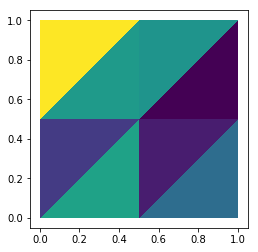

In [5]:
print('lambda_c = ', diffusivityFunction.vector().get_local())
df.plot(diffusivityFunction)

In [6]:
u_c = rom.coarseSolver.solvePDE(diffusivityFunction)

u_c =  [     0.              0.          -4371.25789486      0.          -3676.15591654
 -10206.99959199  -2973.79003488  -7396.10959245  -4567.37182454]


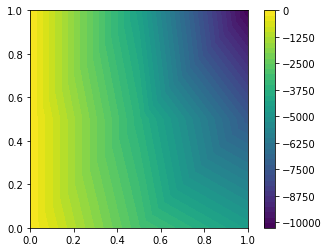

In [7]:
print('u_c = ', u_c.vector().get_local())
puc = df.plot(u_c)
plt.colorbar(puc)

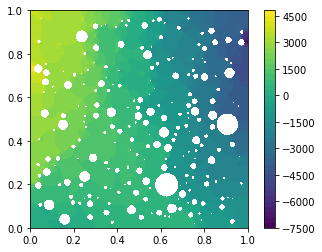

In [8]:
v_n_cp, p_n_cp = stokesData.solution[0].split(deepcopy=True)
ppn = df.plot(p_n_cp)
plt.colorbar(ppn)

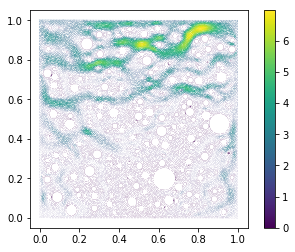

In [9]:
pvn = df.plot(v_n_cp)
plt.colorbar(pvn)

(23212,)


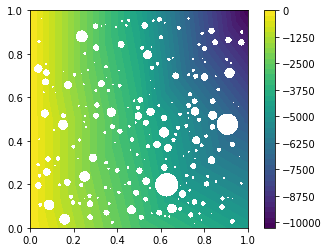

In [10]:
pFineFunSpace = df.FunctionSpace(stokesData.mesh[0], 'CG', 1)
u_f_interp = dfa.interpolate(u_c, pFineFunSpace)
puin = df.plot(u_f_interp)
print(u_f_interp.vector().get_local().shape)
plt.colorbar(puin)

f_64


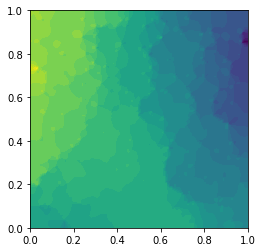

In [11]:
df.plot(stokesData.p_interp[0])
print(stokesData.p_interp[0])

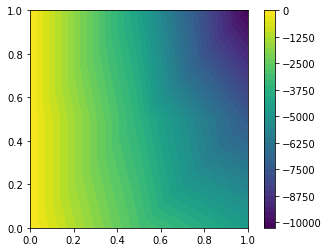

In [12]:
u_f_interp = dfa.interpolate(u_c, stokesData.pInterpFunSpace)
pint = df.plot(u_f_interp)
plt.colorbar(pint)

In [13]:
u_f_interp.vector().get_local().shape

(16641,)

[    0.             0.           -68.30090461 ..., -4542.47210908
 -4611.57085217 -4567.37182454]


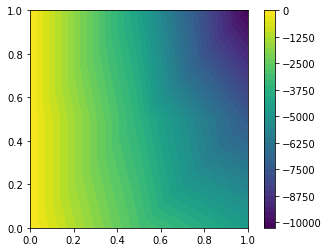

In [14]:
W = computeInterpolationMatrix(rom.coarseSolver.solutionFunctionSpace, stokesData.pInterpFunSpace)
u_interp_mat = W.dot(u_c.vector().get_local())
print(u_interp_mat)
u_f = df.Function(stokesData.pInterpFunSpace)
u_f.vector().set_local(u_interp_mat)
pf = df.plot(u_f)
plt.colorbar(pf)

[-4567.37182454 -4542.47210908 -4581.4358038  ...,     0.           -68.30090461
   -40.01669237]


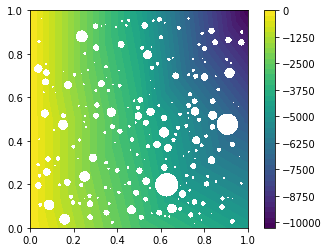

In [15]:
W = computeInterpolationMatrix(rom.coarseSolver.solutionFunctionSpace, p_n_cp.function_space())
u_interp_mat = W.dot(u_c.vector().get_local())
print(u_interp_mat)
u_f = df.Function(p_n_cp.function_space())
u_f.vector().set_local(u_interp_mat)
pf = df.plot(u_f)
plt.colorbar(pf)

In [16]:
constFun = dfa.Function(rom.coarseSolver.diffusivityFunctionSpace)
constFun.vector()[0] = 1.0

In [17]:
dx = df.Measure('dx', stokesData.mesh[0])
volfrac = constFun * dx
volfrac = dfa.assemble(volfrac)
print(volfrac)
volfrac_0 = constFun * df.dx
volfrac_0 = dfa.assemble(volfrac_0)
print(volfrac_0)

0.1069142371839267
0.125


In [18]:
refine_all = df.refine(rom.coarseSolver.mesh)

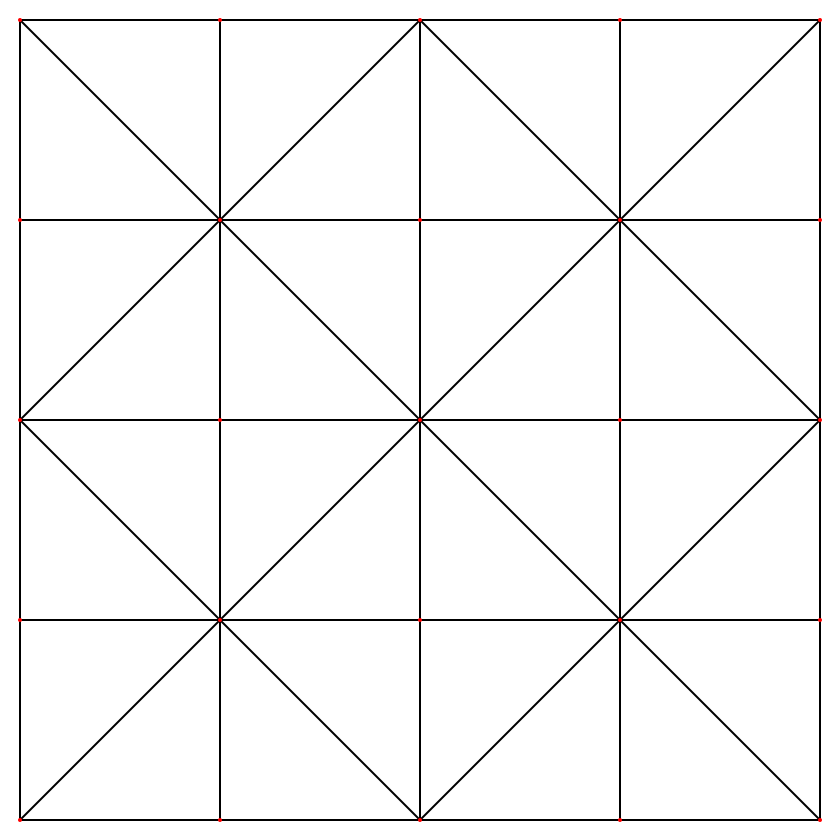

In [19]:
refine_all

In [20]:
cell_markers = df.CellFunction("bool", df.UnitSquareMesh(2, 2, 'left/right'))
cell_markers.set_all(False)
cell_markers[0] = True
refine_0 = df.refine(df.UnitSquareMesh(2, 2, 'left/right'), cell_markers)

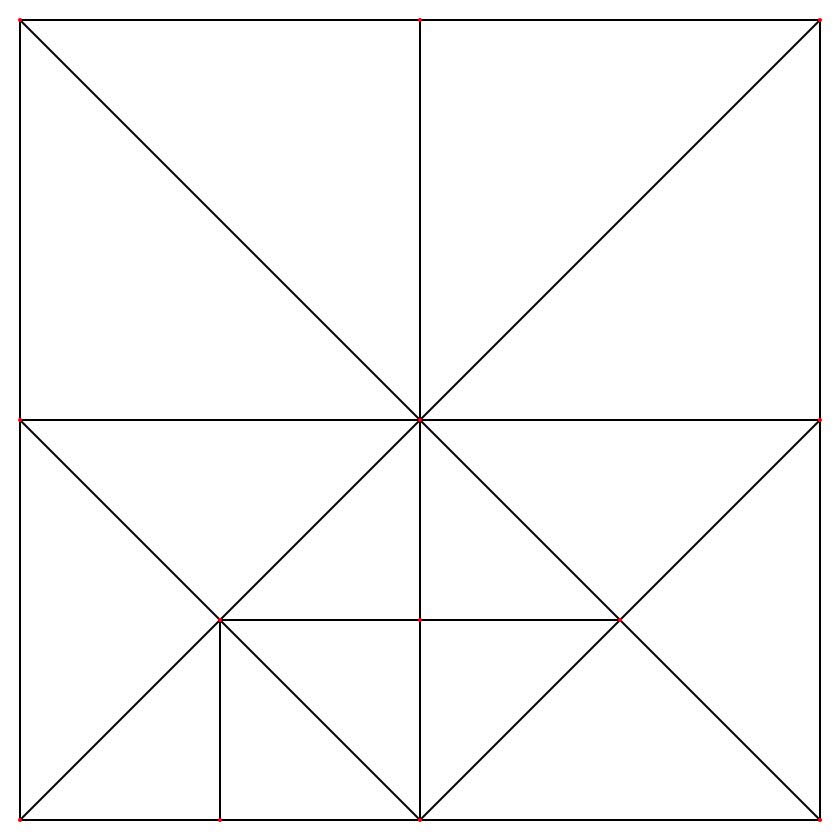

In [21]:
refine_0

In [22]:
refine_0.num_vertices()

13

In [32]:
vals = np.empty(1, dtype=float)
p_n_cp.eval(vals, np.array([0.0, 0.0]))

In [40]:
raise ValueError('bla')

ValueError: bla

RuntimeError: No active exception to reraise